In [1]:
#import
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
import shap

In [2]:
#Reading dataset
df=pd.read_csv('mordred_desc.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Columns: 3227 entries, Yield to mZagreb2.1
dtypes: bool(4), float64(1675), int64(837), object(711)
memory usage: 1.7+ MB


In [3]:
df = df[df.columns.difference(df.select_dtypes(include=['object']).columns)]
df = df[df.columns.difference(df.select_dtypes(include=['bool']).columns)]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Columns: 2512 entries, AATS0Z to piPC9.1
dtypes: float64(1675), int64(837)
memory usage: 1.3 MB


In [4]:
#Preparing

# delete variables with zero variance
Var0Variable = np.where( df.var(axis=0) == 0 )
if len(Var0Variable[0]) == 0:
    print( "There is no variable with zero variance." )
    print( "" )
else:
    print( "There were {0} variables with zero variance".format(len(Var0Variable[0])))
    print( "the number of variable is: {0}".format(Var0Variable[0]) )
    print( "remove them" )
    print( "" )
    #df_var0 = np.delete(df, Var0Variable, 1)    
    df_var0 = df.drop(df.columns[Var0Variable], axis=1)

#removal of columns which data has all 0
def remove_all_zero_col(df):
    df = df.copy()
    for col in df.columns:
        if (df[col] == 0).all():
            df.drop(col, axis=1, inplace=True)
    return df
df_var0 = remove_all_zero_col(df_var0)
df_var0.info()

There were 678 variables with zero variance
the number of variable is: [ 264  290  294  438  460  476  478  480  482  484  486  488  490  492
  494  496  690  692  694  696  698  700  702  704  706  708  710  712
  800  802  804  805  806  809  810  812  813  814  816  838  842  860
  879  880  912 1029 1030 1040 1042 1044 1046 1062 1063 1073 1075 1077
 1079 1242 1246 1254 1268 1270 1311 1312 1313 1314 1315 1316 1317 1318
 1319 1320 1322 1325 1326 1327 1328 1329 1330 1332 1333 1334 1335 1336
 1337 1338 1340 1341 1342 1343 1344 1345 1346 1347 1348 1350 1351 1352
 1353 1354 1355 1356 1357 1358 1360 1364 1366 1367 1368 1369 1370 1371
 1372 1373 1374 1375 1376 1379 1380 1381 1382 1383 1384 1385 1386 1387
 1388 1389 1390 1391 1392 1393 1394 1395 1396 1398 1399 1400 1401 1402
 1403 1404 1407 1408 1409 1410 1411 1412 1413 1414 1415 1416 1417 1418
 1419 1420 1421 1422 1423 1424 1425 1426 1427 1428 1429 1430 1431 1432
 1433 1434 1435 1436 1437 1438 1439 1440 1441 1442 1443 1444 1446 1447
 1448 

In [5]:
#Building descriptors
X = df_var0.drop(columns=['Yield'])

print('---Descriptors---')
print(X.head())

y = pd.DataFrame(df_var0['Yield'],columns=['Yield'])
print('---Objective---')
print(y.head())

---Descriptors---
      AATS0Z   AATS0Z.1  AATS0are  AATS0are.1    AATS0d  AATS0d.1   AATS0dv  \
0  25.000000  38.153846  6.502857    6.721046  3.000000  2.076923  8.428571   
1  25.000000  60.000000  6.502857    7.930514  3.000000  2.142857  8.428571   
2  25.000000  36.000000  6.502857    6.257725  3.000000  2.937500  8.428571   
3  25.000000  59.333333  6.502857    7.210600  3.000000  1.500000  8.428571   
4  22.823529  38.153846  6.292353    6.721046  2.941176  2.076923  7.411765   

   AATS0dv.1      AATS0i    AATS0i.1  ...     piPC4   piPC4.1    piPC5  \
0   8.476733  160.083901  170.333600  ...  3.803881  0.693147  4.20189   
1  12.313933  160.083901  174.439640  ...  3.803881  0.000000  4.20189   
2   7.637346  160.083901  158.503934  ...  3.803881  3.944006  4.20189   
3  10.185185  160.083901  172.604366  ...  3.803881  0.000000  4.20189   
4   8.476733  161.047311  170.333600  ...  3.986667  0.693147  4.42709   

    piPC5.1     piPC6   piPC6.1     piPC7   piPC7.1  piPC8  pi

In [6]:
#storage 
data_r2_train =[]
data_RMSE_train = []
data_MAE_train = []
data_r2_test = []
data_RMSE_test = []
data_MAE_test = []
best_model_parametors = []
data_cv_score = []

#MLP_a_X,y/10
for i in range(10):
    seed=i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    
    #autoscaling
    a_X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
    a_X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1) 
    a_X_train=a_X_train.dropna(axis=1)
    a_X_test=a_X_test[a_X_train.columns]
    
    a_y_train = y_train / 10

    param_mlp={'hidden_layer_sizes':[(32,32,32,32,),(400,)], 'alpha':[1,2,3,4,5], 'max_iter':[5000],
               'learning_rate_init':[0.003,0.03]}
    
    reg_mlp = GridSearchCV(MLPRegressor(random_state=0), param_grid=param_mlp, cv=5, n_jobs=3)
    reg_mlp.fit(a_X_train,a_y_train['Yield'])
    reg_best = reg_mlp.best_estimator_
    y_pred1 = reg_best.predict(a_X_train)*10
    y_pred2 = reg_best.predict(a_X_test)*10
            
    #train
    r2_train = metrics.r2_score(y_train, y_pred1)
    RMSE_train = metrics.mean_squared_error(y_train, y_pred1)
    MAE_train =  metrics.mean_absolute_error(y_train, y_pred1)
    
    #test
    r2_test = metrics.r2_score(y_test, y_pred2)
    RMSE_test = metrics.mean_squared_error(y_test, y_pred2)
    MAE_test = metrics.mean_absolute_error(y_test, y_pred2)
    
    data_r2_train.append(r2_train)
    data_RMSE_train.append(RMSE_train)
    data_MAE_train.append(MAE_train)
    data_r2_test.append(r2_test)
    data_RMSE_test.append(RMSE_test)
    data_MAE_test.append(MAE_test)
    data_cv_score.append(reg_mlp.best_score_)

    print('----------------------')
    print('seed:', seed)
    print('X_dim.',len(a_X_train.columns))
    print("Best Model Parameter:",reg_mlp.best_params_)
    print("Best Model Score:",reg_mlp.best_score_)
    print('R2_test:', r2_test)
print('R2_train_means:', sum(data_r2_train)/10)
print('CV_score_means:', sum(data_cv_score)/10)
print('R2_test_means:', sum(data_r2_test)/10)

----------------------
seed: 0
X_dim. 1833
Best Model Parameter: {'alpha': 3, 'hidden_layer_sizes': (32, 32, 32, 32), 'learning_rate_init': 0.003, 'max_iter': 5000}
Best Model Score: 0.5941736092300538
R2_test: 0.7742550103527324
----------------------
seed: 1
X_dim. 1833
Best Model Parameter: {'alpha': 5, 'hidden_layer_sizes': (32, 32, 32, 32), 'learning_rate_init': 0.003, 'max_iter': 5000}
Best Model Score: 0.77298894955616
R2_test: 0.828932048597568
----------------------
seed: 2
X_dim. 1833
Best Model Parameter: {'alpha': 5, 'hidden_layer_sizes': (32, 32, 32, 32), 'learning_rate_init': 0.003, 'max_iter': 5000}
Best Model Score: 0.7094422557031629
R2_test: 0.8617488635125716
----------------------
seed: 3
X_dim. 1833
Best Model Parameter: {'alpha': 2, 'hidden_layer_sizes': (32, 32, 32, 32), 'learning_rate_init': 0.003, 'max_iter': 5000}
Best Model Score: 0.6601051291300226
R2_test: 0.8367286601334667
----------------------
seed: 4
X_dim. 1833
Best Model Parameter: {'alpha': 1, 'hidd

In [7]:
data_r2_train_pd = pd.DataFrame(data= data_r2_train, columns=['r2_train'])
data_RMSE_train_pd = pd.DataFrame(data=data_RMSE_train, columns=['MSE_train'])
data_MAE_train_pd = pd.DataFrame(data=data_MAE_train, columns=['MAE_train'])
data_r2_test_pd = pd.DataFrame(data=data_r2_test, columns=['r2_test'])
data_RMSE_test_pd = pd.DataFrame(data=data_RMSE_test, columns=['MSE_test'])
data_MAE_test_pd = pd.DataFrame(data=data_MAE_test, columns=['MAE_test'])
data_cv_score_pd = pd.DataFrame(data=data_cv_score, columns=['cv_score'])
data_parametors = pd.DataFrame([best_model_parametors])
        
data_all = pd.concat([data_r2_train_pd, data_RMSE_train_pd, data_MAE_train_pd, data_r2_test_pd, data_RMSE_test_pd, data_MAE_test_pd, data_cv_score_pd], 
                     axis=1, join='inner')
data_all.loc['mean'] = data_all.mean()
print(data_all)
data_all.to_csv('../../score/Mordred/MLP_score.csv')

      r2_train  MSE_train  MAE_train   r2_test    MSE_test   MAE_test  \
0     0.998401   1.178659   0.845319  0.774255  295.263185  11.075887   
1     0.998288   1.547866   0.973865  0.828932  165.738855   9.193094   
2     0.998758   1.149176   0.781987  0.861749  133.697313   7.851335   
3     0.999001   0.931680   0.760319  0.836729  156.699021   8.836942   
4     0.999111   0.766234   0.658530  0.810613  201.379517   9.346980   
5     0.997397   2.108018   1.069657  0.910188  109.229932   5.883333   
6     0.998894   0.907919   0.703059  0.844709  186.886845   8.724439   
7     0.998798   1.150053   0.834742  0.730051  244.711060   9.348561   
8     0.988180  10.403382   2.244092  0.767409  229.854963  10.651402   
9     0.999891   0.110400   0.199008  0.858972   99.376349   7.568570   
mean  0.997672   2.025339   0.907058  0.822361  182.283704   8.848054   

      cv_score  
0     0.594174  
1     0.772989  
2     0.709442  
3     0.660105  
4     0.815136  
5     0.538172  
6   

In [8]:
seed=5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

#autoscaling
a_X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
a_X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1) 
a_X_train=a_X_train.dropna(axis=1)
a_X_test=a_X_test[a_X_train.columns]
a_y_train = y_train / 10

param_mlp={'hidden_layer_sizes':[(32,32,32,32,),(400,)], 'alpha':[1,2,3,4,5], 'max_iter':[5000],
           'learning_rate_init':[0.003,0.03]}
    
reg_mlp = GridSearchCV(MLPRegressor(random_state=0), param_grid=param_mlp, cv=5, n_jobs=2)
reg_mlp.fit(a_X_train,a_y_train['Yield'])
reg_best = reg_mlp.best_estimator_
y_pred1 = reg_best.predict(a_X_train)*10
y_pred2 = reg_best.predict(a_X_test)*10
            
#train
r2_train = metrics.r2_score(y_train, y_pred1)
RMSE_train = metrics.mean_squared_error(y_train, y_pred1)
MAE_train =  metrics.mean_absolute_error(y_train, y_pred1)
#test
r2_test = metrics.r2_score(y_test, y_pred2)
RMSE_test = metrics.mean_squared_error(y_test, y_pred2)
MAE_test = metrics.mean_absolute_error(y_test, y_pred2)
print('R2_train:', r2_train)
print('R2_test:', r2_test)

R2_train: 0.9973966671295981
R2_test: 0.9101878262015429


  0%|          | 0/47 [00:00<?, ?it/s]

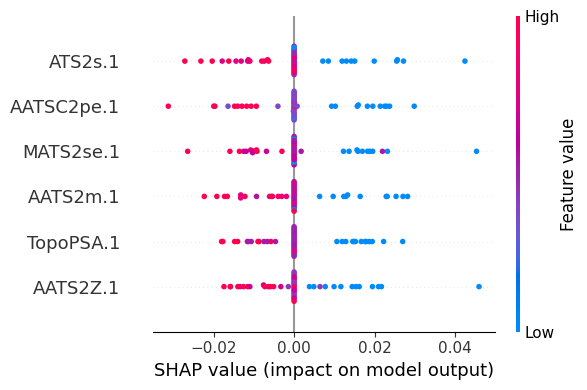

In [9]:
# explain all the predictions in the test set
explainer = shap.KernelExplainer(reg_best.predict, a_X_train)
shap_values = explainer.shap_values(a_X_train)
shap.summary_plot(shap_values, a_X_train,max_display=6, plot_size=(6,4))